In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("AAPL.csv",parse_dates=["Date"],index_col=[0])
print(df.index.freq)
missing_dates = pd.date_range(start=df.index.min(), end=df.index.max()).difference(df.index)
print(missing_dates)
df.shape

None
DatetimeIndex(['2022-07-02', '2022-07-03', '2022-07-04', '2022-07-09',
               '2022-07-10', '2022-07-16', '2022-07-17', '2022-07-23',
               '2022-07-24', '2022-07-30',
               ...
               '2023-05-29', '2023-06-03', '2023-06-04', '2023-06-10',
               '2023-06-11', '2023-06-17', '2023-06-18', '2023-06-19',
               '2023-06-24', '2023-06-25'],
              dtype='datetime64[ns]', length=114, freq=None)


(251, 6)

In [3]:
# Dropping the specified columns
df.drop(columns=["Open", "Close", "Adj Close", "Volume"], inplace=True)

# Calculate the midpoint of low and high and save it as 'Mid'
df["Mid"] = (df["Low"] + df["High"]) / 2
df.to_csv('apple.csv')
df.head()

,High,Low,Mid
Date,,,
2022-07-01,139.039993,135.660004,137.349998
2022-07-05,141.610001,136.929993,139.269997
2022-07-06,144.119995,141.080002,142.599998
2022-07-07,146.550003,143.279999,144.915001
2022-07-08,147.550003,145.000000,146.275002


In [4]:
def train_test_split(data, prediction_size):
    train_size = int(len(data) * (1-prediction_size))
    train = pd.DataFrame(data[0:train_size])
    test = pd.DataFrame(data[train_size:len(data)])
    return train, test
df_train, df_test = train_test_split(df, 0.2)

In [5]:
print(df_train.shape)
print(df_test.shape)

(200, 3)
(51, 3)


In [6]:
# 归一化
scaler = MinMaxScaler(feature_range=(0,1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

In [7]:
len(df_test_scaled)

51

In [8]:
def generate_time_series_data(input_data, history_length):
    X_data, Y_data = [], []

    for idx in range(history_length, len(input_data)):
        X_data.append(input_data[idx-history_length :idx, 0:input_data.shape[1]])
#         Y_data.append(input_data[idx, 0:input_data.shape[1]]) #这是沿第二个维度（特征）的切片，从第一个特征开始，到最后一个特征结束。简而言之，我们选择了所有的特征。
        Y_data.append(input_data[idx, 0])
    return np.array(X_data), np.array(Y_data)

In [9]:
df_train.shape[1]

3

In [10]:
trainX,trainY=generate_time_series_data(df_train_scaled,5)
testX,testY=generate_time_series_data(df_test_scaled,5)
print("trainX Shape-- ",trainX.shape) #trainX consists of 1984 time Windows, each consisting of 30 consecutive time steps with 6 features per time step
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX Shape--  (195, 5, 3)
trainY Shape--  (195,)
testX Shape--  (46, 5, 3)
testY Shape--  (46,)
trainX[0]-- 
 [[0.23294743 0.23472945 0.23048131]
 [0.28606872 0.26067407 0.27040227]
 [0.33794955 0.34545465 0.33964027]
 [0.38817708 0.39039841 0.38777422]
 [0.40884678 0.42553633 0.4160516 ]]

trainY[0]--  0.390037270982055


In [11]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(5,3), activation='relu'))
    grid_model.add(Dropout(0.2))
    grid_model.add(LSTM(units=50, activation='relu'))
    grid_model.add(Dense(units=1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [8, 16, 32],
              'epochs' : [5, 10, 20],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\eq220\AppData\Local\Temp\ipykernel_44472\3441814425.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [12]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/5
13/13 [==============================] - 1s 20ms/step - loss: 0.1991 - val_loss: 0.7371
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 0.0819 - val_loss: 0.0521
Epoch 3/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0064
Epoch 4/5
13/13 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0190
Epoch 5/5
13/13 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 1/5
13/13 [==============================] - 1s 18ms/step - loss: 0.2336 - val_loss: 0.3358
Epoch 2/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0416 - val_loss: 0.0315
Epoch 3/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0580
Epoch 4/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0148 - val_loss: 0.0096
Epoch 5/5
13/13 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 1/5
13/13 [==============================] - 1s 18ms/step - 

13/13 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 1/20
13/13 [==============================] - 2s 18ms/step - loss: 0.2120 - val_loss: 0.3456
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0402 - val_loss: 0.0348
Epoch 3/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0187 - val_loss: 0.0496
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0122 - val_loss: 0.0079
Epoch 5/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.0097
Epoch 6/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.0132
Epoch 7/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0102 - val_loss: 0.0079
Epoch 8/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 9/20
13/13 [==============================

7/7 [==============================] - 0s 6ms/step - loss: 0.3479 - val_loss: 1.1028
Epoch 4/5
7/7 [==============================] - 0s 7ms/step - loss: 0.3481 - val_loss: 1.1026
Epoch 5/5
7/7 [==============================] - 0s 2ms/step - loss: 0.2328
Epoch 1/10
7/7 [==============================] - 1s 32ms/step - loss: 0.1944 - val_loss: 0.7705
Epoch 2/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1248 - val_loss: 0.4170
Epoch 3/10
7/7 [==============================] - 0s 7ms/step - loss: 0.0479 - val_loss: 0.0337
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0746
Epoch 5/10
7/7 [==============================] - 0s 6ms/step - loss: 0.0192 - val_loss: 0.0097
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0355
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0041
Epoch 8/10
7/7 [==============================] - 0s 8ms/step - loss: 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0024
Epoch 20/20
7/7 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 1/20
7/7 [==============================] - 1s 35ms/step - loss: 0.2686 - val_loss: 1.2736
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2691 - val_loss: 1.2732
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2692 - val_loss: 1.2728
Epoch 4/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2681 - val_loss: 1.2723
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2683 - val_loss: 1.2719
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2684 - val_loss: 1.2715
Epoch 7/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2682 - val_loss: 1.2710
Epoch 8/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2675 - val_loss: 1.2707
Epoch 9/20
7/7 [==============================] - 0s 7ms/step - loss

4/4 [==============================] - 0s 11ms/step - loss: 0.0553 - val_loss: 0.0801
Epoch 9/10
4/4 [==============================] - 0s 11ms/step - loss: 0.0160 - val_loss: 0.0068
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 1/10
4/4 [==============================] - 1s 63ms/step - loss: 0.2343 - val_loss: 1.1077
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 0.2334 - val_loss: 1.1076
Epoch 3/10
4/4 [==============================] - 0s 11ms/step - loss: 0.2341 - val_loss: 1.1075
Epoch 4/10
4/4 [==============================] - 0s 11ms/step - loss: 0.2340 - val_loss: 1.1073
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 0.2341 - val_loss: 1.1072
Epoch 6/10
4/4 [==============================] - 0s 10ms/step - loss: 0.2342 - val_loss: 1.1071
Epoch 7/10
4/4 [==============================] - 0s 11ms/step - loss: 0.2339 - val_loss: 1.1069
Epoch 8/10
4/4 [==============================] - 0s 11ms/st

Epoch 19/20
4/4 [==============================] - 0s 11ms/step - loss: 0.2511 - val_loss: 1.1889
Epoch 20/20
4/4 [==============================] - 0s 2ms/step - loss: 0.3720
Epoch 1/20
4/4 [==============================] - 1s 62ms/step - loss: 0.3240 - val_loss: 1.0475
Epoch 2/20
4/4 [==============================] - 0s 11ms/step - loss: 0.3229 - val_loss: 1.0473
Epoch 3/20
4/4 [==============================] - 0s 11ms/step - loss: 0.3238 - val_loss: 1.0471
Epoch 4/20
4/4 [==============================] - 0s 11ms/step - loss: 0.3231 - val_loss: 1.0469
Epoch 5/20
4/4 [==============================] - 0s 10ms/step - loss: 0.3238 - val_loss: 1.0467
Epoch 6/20
4/4 [==============================] - 0s 11ms/step - loss: 0.3228 - val_loss: 1.0464
Epoch 7/20
4/4 [==============================] - 0s 11ms/step - loss: 0.3227 - val_loss: 1.0462
Epoch 8/20
4/4 [==============================] - 0s 11ms/step - loss: 0.3227 - val_loss: 1.0460
Epoch 9/20
4/4 [==============================] 

In [13]:
grid_search.best_params_

{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam'}

Epoch 1/20
25/25 [==============================] - 1s 11ms/step - loss: 0.1976 - val_loss: 0.2775
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0314 - val_loss: 0.0037
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0048
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0129 - val_loss: 0.0081
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.0059
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0037
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0076
Epoch 8/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0085
Epoch 9/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0129 - val_loss: 0.0070
Epoch 10/20
25/25 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0084
Epoch 11/20
25/25 

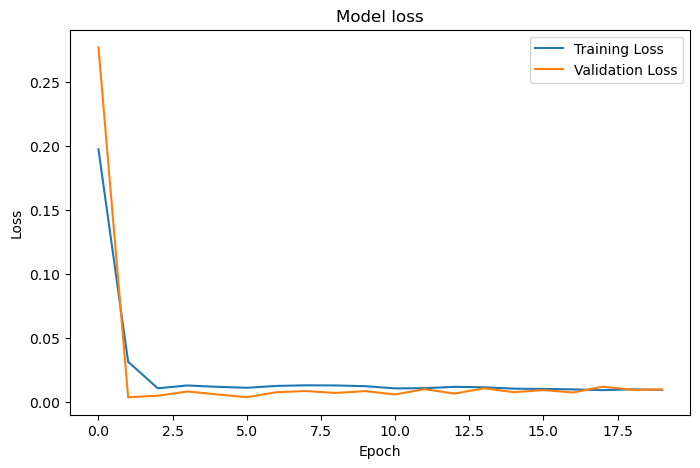

In [14]:
import matplotlib.pyplot as plt

# Execute grid search
# grid_search.fit(trainX, trainY)

# Extract best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train model using the best hyperparameters
best_model = build_model(optimizer=best_params['optimizer'])
history = best_model.fit(trainX, trainY, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(testX, testY), verbose=1, shuffle=False)

# Plot training & validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [36]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from tensorflow.keras.optimizers import Adam


# 定义超参数空间
space  = [Integer(10, 50, name='lstm_neurons'),
          Real(0.2, 0.9, name='dropout_rate'),
          Real(1e-4, 1e-2, name='learning_rate', prior='log-uniform')]

# 定义优化目标函数
@use_named_args(space)
def objective(**params):
    # 在这里构建您的 LSTM 模型
    model = Sequential()
    model.add(LSTM(params['lstm_neurons'], input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    
    history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX, testY), verbose=0, shuffle=False)
    
    # 返回验证损失
    return history.history['val_loss'][-1]

# 执行贝叶斯优化
res = gp_minimize(objective, space, n_calls=50, random_state=0)

# 输出最佳参数
print("Best parameters: {}".format(res.x))

Best parameters: [42, 0.2, 0.0004780881960145376]


In [37]:
best_lstm_neurons = res.x[0]
best_dropout_rate = res.x[1]
best_learning_rate = res.x[2]

model = Sequential()
model.add(LSTM(units=best_lstm_neurons, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]), activation='relu'))
model.add(Dropout(best_dropout_rate))
model.add(LSTM(units=best_lstm_neurons, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='mse')

history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX, testY), verbose=1, shuffle=False)

Epoch 1/20
25/25 [==============================] - 1s 10ms/step - loss: 0.2379 - val_loss: 0.6322
Epoch 2/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0779 - val_loss: 0.0617
Epoch 3/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0035
Epoch 4/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0238
Epoch 5/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0080
Epoch 6/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 7/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0044
Epoch 8/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0049
Epoch 9/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0037
Epoch 10/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0036
Epoch 11/20
25/25 

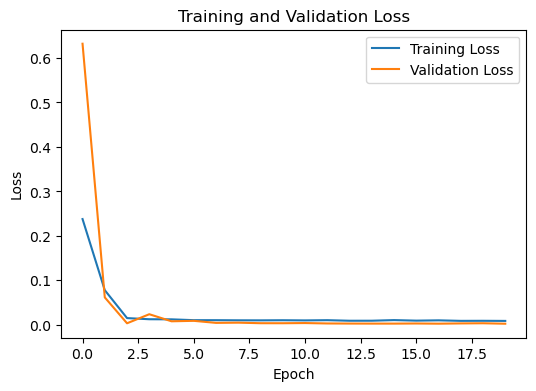

In [38]:
import matplotlib.pyplot as plt

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [39]:
prediction = model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

2/2 [==============================] - 0s 1ms/step
prediction
 [[0.8052903 ]
 [0.7939794 ]
 [0.7908851 ]
 [0.80425245]
 [0.82281107]
 [0.8411091 ]
 [0.865909  ]
 [0.8649274 ]
 [0.8734679 ]
 [0.88824016]
 [0.9034715 ]
 [0.92445815]
 [0.96476734]
 [0.96559834]
 [0.962938  ]
 [0.9633054 ]
 [0.95743   ]
 [0.9577222 ]
 [0.97077423]
 [0.978568  ]
 [0.98096853]
 [0.98337847]
 [0.9779132 ]
 [0.9689155 ]
 [0.9803009 ]
 [1.0051861 ]
 [1.0412573 ]
 [1.0812451 ]
 [1.1158673 ]
 [1.1230322 ]
 [1.1316557 ]
 [1.1367755 ]
 [1.1387056 ]
 [1.1410354 ]
 [1.16383   ]
 [1.1862009 ]
 [1.2200832 ]
 [1.2414219 ]
 [1.2581751 ]
 [1.2643853 ]
 [1.2774031 ]
 [1.2823837 ]
 [1.2854892 ]
 [1.2942532 ]
 [1.3209645 ]
 [1.3438957 ]]

Prediction Shape- (46, 1)


In [40]:
prediction_copies = np.repeat(prediction, 3, axis=-1)
inverse_transformed_datas = scaler.inverse_transform(prediction_copies)
# pred=scaler.inverse_transform(prediction_copies)

In [41]:
pred=scaler.inverse_transform(prediction_copies)

In [42]:
original_copies_array = np.repeat(testY, 3, axis=-1)

original_copies_array.shape

original = scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),3)))

In [43]:
pred

array([[166.72995, 163.58896, 164.99544],
       [166.18271, 163.0353 , 164.45143],
       [166.03302, 162.88382, 164.30263],
       [166.67973, 163.53815, 164.94553],
       [167.57759, 164.4466 , 165.8381 ],
       [168.46286, 165.34229, 166.71814],
       [169.66267, 166.55623, 167.91089],
       [169.61519, 166.5082 , 167.8637 ],
       [170.02837, 166.92625, 168.27443],
       [170.74306, 167.64935, 168.98491],
       [171.47995, 168.39493, 169.71747],
       [172.49529, 169.42221, 170.72682],
       [174.44543, 171.39536, 172.66548],
       [174.48564, 171.43604, 172.70544],
       [174.35693, 171.30582, 172.5775 ],
       [174.37471, 171.32379, 172.59517],
       [174.09045, 171.0362 , 172.31259],
       [174.10458, 171.05049, 172.32664],
       [174.73605, 171.68939, 172.95439],
       [175.11311, 172.0709 , 173.32922],
       [175.22926, 172.1884 , 173.44469],
       [175.34586, 172.30637, 173.5606 ],
       [175.08144, 172.03885, 173.29774],
       [174.64613, 171.5984 , 172.

In [44]:
pred_High = pred[:, 0]
pred_Low = pred[:, 1]
pred_Mid = pred[:, 2]

# Adjusting the date_range to match the length of pred_High, pred_Low, and pred_Mid
df_test_dropped = df_test.iloc[5:]
date = df_test_dropped.index.tolist()

# Combining the adjusted data
pred_data = pd.DataFrame({
    'Date': date,
    'pred_High': pred_High,
    'pred_Low': pred_Low,
    'pred_Mid': pred_Mid
})

pred_data.head()

,Date,pred_High,pred_Low,pred_Mid
0,2023-04-26,166.729950,163.588959,164.995438
1,2023-04-27,166.182709,163.035294,164.451431
2,2023-04-28,166.033020,162.883820,164.302628
3,2023-05-01,166.679733,163.538147,164.945526
4,2023-05-02,167.577591,164.446594,165.838104


In [45]:
original

array([[165.279999  , 162.12193267, 163.55403827],
       [168.559998  , 165.44057573, 166.81471551],
       [169.850006  , 166.74578225, 168.09712435],
       [170.449997  , 167.35284218, 168.69358094],
       [170.350006  , 167.25167311, 168.59417896],
       [170.919998  , 167.82838061, 169.16081326],
       [167.039993  , 163.90266244, 165.30366453],
       [174.300003  , 171.24820791, 172.52090739],
       [173.850006  , 170.79290917, 172.07356123],
       [173.539993  , 170.47924368, 171.76537445],
       [174.029999  , 170.97502279, 172.25249393],
       [174.589996  , 171.54161753, 172.80919211],
       [174.059998  , 171.00537523, 172.28231621],
       [173.210007  , 170.14536987, 171.43733232],
       [173.139999  , 170.07453706, 171.36773672],
       [172.929993  , 169.86205682, 171.15896782],
       [175.240005  , 172.19928476, 173.45537205],
       [176.389999  , 173.36282767, 174.59859168],
       [174.710007  , 171.66304246, 172.92849615],
       [173.380005  , 170.31737

In [46]:
original_High = original[:, 0]
original_Low = original[:, 1]
original_Mid = original[:, 2]

# Adjusting the date_range to match the length of pred_High, pred_Low, and pred_Mid
df_test_dropped = df_test.iloc[5:]
date = df_test_dropped.index.tolist()

# Combining the adjusted data
original_data = pd.DataFrame({
    'Date': date,
    'original_High': original_High,
    'original_Low': original_Low,
    'original_Mid': original_Mid
})

original_data.head()

,Date,original_High,original_Low,original_Mid
0,2023-04-26,165.279999,162.121933,163.554038
1,2023-04-27,168.559998,165.440576,166.814716
2,2023-04-28,169.850006,166.745782,168.097124
3,2023-05-01,170.449997,167.352842,168.693581
4,2023-05-02,170.350006,167.251673,168.594179


In [47]:
merged_data = pd.merge(pred_data, original_data, on='Date')
merged_data.head()

,Date,pred_High,pred_Low,pred_Mid,original_High,original_Low,original_Mid
0,2023-04-26,166.729950,163.588959,164.995438,165.279999,162.121933,163.554038
1,2023-04-27,166.182709,163.035294,164.451431,168.559998,165.440576,166.814716
2,2023-04-28,166.033020,162.883820,164.302628,169.850006,166.745782,168.097124
3,2023-05-01,166.679733,163.538147,164.945526,170.449997,167.352842,168.693581
4,2023-05-02,167.577591,164.446594,165.838104,170.350006,167.251673,168.594179


In [48]:
# Calculating MSE, MAE and RMSE for Low_price, High_price and Mid_price

def calculate_metrics(pred, original):
    mse = np.mean((np.array(pred) - np.array(original))**2)
    mae = np.mean(np.abs(np.array(pred) - np.array(original)))
    rmse = np.sqrt(mse)
    return mse, mae, rmse

low_metrics = calculate_metrics(pred_Low, original_Low)
high_metrics = calculate_metrics(pred_High, original_High)
mid_metrics = calculate_metrics(pred_Mid, original_Mid)

low_metrics, high_metrics, mid_metrics

((5.962952302822289, 2.093856552191961, 2.441915703463633),
 (5.824889543481759, 2.0694754971340017, 2.4134807940983825),
 (5.756463049628695, 2.057284245621091, 2.399263022185916))

In [49]:
df_dates = df.index[-len(original):]

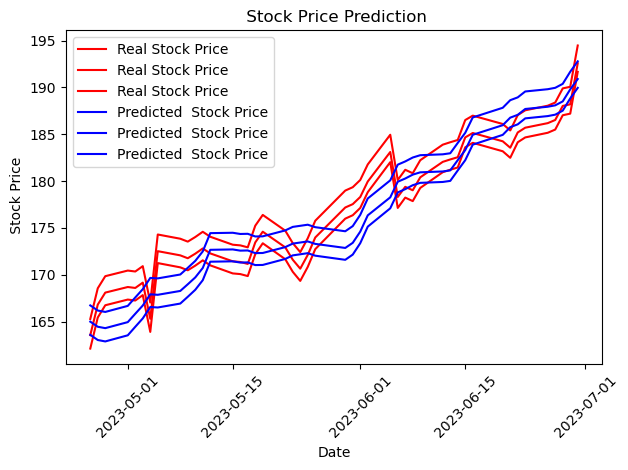

In [50]:
plt.plot(df_dates, original, color = 'red', label = 'Real Stock Price')
plt.plot(df_dates, pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel(' Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

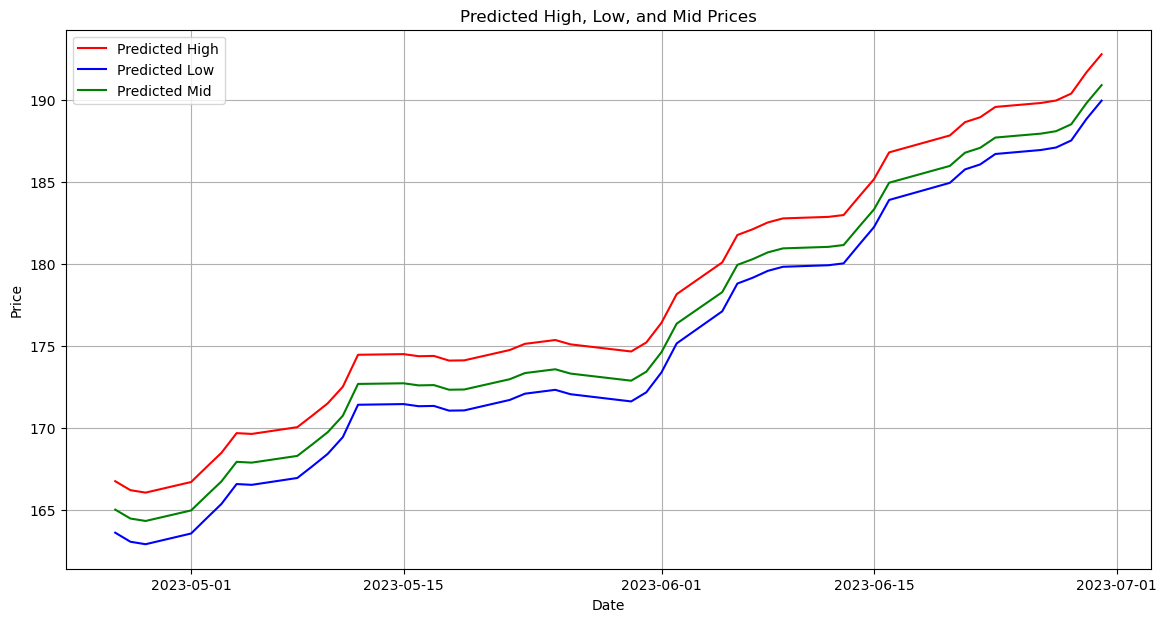

In [51]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(df_dates, pred_High, label='Predicted High', color='red')
plt.plot(df_dates, pred_Low, label='Predicted Low', color='blue')
plt.plot(df_dates, pred_Mid, label='Predicted Mid', color='green')
plt.title('Predicted High, Low, and Mid Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [52]:

def trade_strategy(forecast, real, initial_capital):
    capital = initial_capital
    shares = 0
    buy_dates = []
    sell_dates = []

    for i in range(len(forecast) - 1):
        date = forecast.index[i]
        current_price = real[date]
        next_price = forecast.iloc[i + 1]

        if next_price > current_price and shares == 0:
            shares = capital // current_price
            capital -= shares * current_price
            buy_dates.append(date)

        elif next_price < current_price and shares > 0:
            capital += shares * current_price
            shares = 0
            sell_dates.append(date)

    if shares > 0:
        capital += shares * real.iloc[-1]
        sell_dates.append(forecast.index[-1])

    return capital, buy_dates, sell_dates


pred_price = pred_data.set_index('Date')['pred_Mid']
original_price = original_data.set_index('Date')['original_Mid']


# Creating pandas Series for pred_Mid and original_Mid
# forecast_price = pd.Series(pred_Mid, index=date_range, name='forecast_midpoint')
# real_price = pd.Series(original_Mid, index=date_range, name='real_midpoint')

# Execute the trading strategy again
capital_after_trade, buy_dates, sell_dates = trade_strategy(pred_price, original_price, 100000)

print(f"After implementing the trading strategy, the total capital stands at: ${capital_after_trade:.2f}")
print(f"We buy stocks on these dates: {buy_dates}")
print(f"We sell stocks on these dates: {sell_dates}")

After implementing the trading strategy, the total capital stands at: $116116.21
We buy stocks on these dates: [Timestamp('2023-04-26 00:00:00'), Timestamp('2023-05-04 00:00:00'), Timestamp('2023-05-12 00:00:00'), Timestamp('2023-05-22 00:00:00'), Timestamp('2023-06-06 00:00:00'), Timestamp('2023-06-14 00:00:00')]
We sell stocks on these dates: [Timestamp('2023-04-27 00:00:00'), Timestamp('2023-05-05 00:00:00'), Timestamp('2023-05-18 00:00:00'), Timestamp('2023-05-26 00:00:00'), Timestamp('2023-06-12 00:00:00'), Timestamp('2023-06-30 00:00:00')]


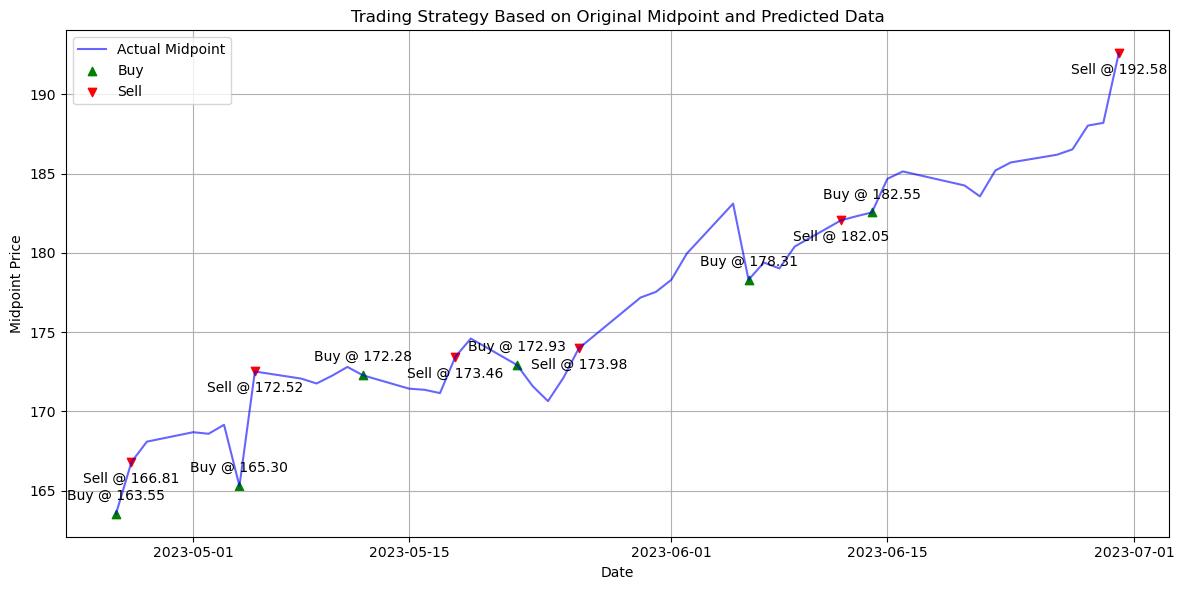

In [53]:
# Filter the original_price to only have dates that are in pred_price
filtered_original_prices = original_price[original_price.index.isin(pred_price.index)]

# Filter buy and sell dates based on the dates in pred_price
filtered_buy_dates = [date for date in buy_dates if date in pred_price.index]
filtered_sell_dates = [date for date in sell_dates if date in pred_price.index]
filtered_dates = filtered_original_prices.index

plt.figure(figsize=(12,6))
plt.plot(filtered_dates, filtered_original_prices, label="Actual Midpoint", color="blue", alpha=0.6)

# Highlight the buy and sell points
plt.scatter(filtered_buy_dates, filtered_original_prices.loc[filtered_buy_dates], color="green", label="Buy", marker="^", alpha=1)
plt.scatter(filtered_sell_dates, filtered_original_prices.loc[filtered_sell_dates], color="red", label="Sell", marker="v", alpha=1)

# Annotate the buy and sell points
for buy_date in filtered_buy_dates:
    price = filtered_original_prices.loc[buy_date]
    plt.annotate(f"Buy @ {price:.2f}", (buy_date, price), textcoords="offset points", xytext=(0,10), ha='center')
for sell_date in filtered_sell_dates:
    price = filtered_original_prices.loc[sell_date]
    plt.annotate(f"Sell @ {price:.2f}", (sell_date, price), textcoords="offset points", xytext=(0,-15), ha='center')

plt.title("Trading Strategy Based on Original Midpoint and Predicted Data")
plt.xlabel("Date")
plt.ylabel("Midpoint Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
merged_data['original_Low'] = merged_data['original_Low'].shift(-1)
merged_data['original_High'] = merged_data['original_High'].shift(-1)
merged_data['original_Mid'] = merged_data['original_Mid'].shift(-1)

def generate_signal(row):
    if row['pred_High'] <= row['original_Mid']:
        return 'Sell'
    elif row['pred_Low'] >= row['original_Mid']:
        return 'Buy'
    else:
        return 'Hold'

merged_data['Signal'] = merged_data.apply(generate_signal, axis=1)
merged_data[['Date', 'pred_Low', 'pred_High', 'original_Low', 'original_High', 'original_Mid', 'Signal']].head(10)

,Date,pred_Low,pred_High,original_Low,original_High,original_Mid,Signal
0,2023-04-26,163.588959,166.729950,165.440576,168.559998,166.814716,Sell
1,2023-04-27,163.035294,166.182709,166.745782,169.850006,168.097124,Sell
2,2023-04-28,162.883820,166.033020,167.352842,170.449997,168.693581,Sell
3,2023-05-01,163.538147,166.679733,167.251673,170.350006,168.594179,Sell
4,2023-05-02,164.446594,167.577591,167.828381,170.919998,169.160813,Sell
5,2023-05-03,165.342285,168.462860,163.902662,167.039993,165.303665,Buy
6,2023-05-04,166.556229,169.662674,171.248208,174.300003,172.520907,Sell
7,2023-05-05,166.508194,169.615189,170.792909,173.850006,172.073561,Sell
8,2023-05-08,166.926254,170.028366,170.479244,173.539993,171.765374,Sell
9,2023-05-09,167.649353,170.743057,170.975023,174.029999,172.252494,Sell


In [55]:
initial_balance = 100000
balance = initial_balance
stock_quantity = 0

# iloc[:-1] is used to avoid NaN in the last row due to the shift operation earlier
for _, row in merged_data.iloc[:-1].iterrows():
    if row['Signal'] == 'Buy' and balance > 0:
        stock_quantity = balance / row['original_Mid']
        balance = 0
    elif row['Signal'] == 'Sell' and stock_quantity > 0:
        balance = stock_quantity * row['original_Mid']
        stock_quantity = 0

# balance + value of stocks held, iloc[-2] means use the penultimate day's data (as the last row might contain NaN due to the shift operation)
final_wealth = balance + stock_quantity * merged_data['original_Mid'].iloc[-2]
print(f"After implementing the above trading strategy, the total capital stands at: ${final_wealth}")

After implementing the above trading strategy, the total capital stands at: $118815.10258592584


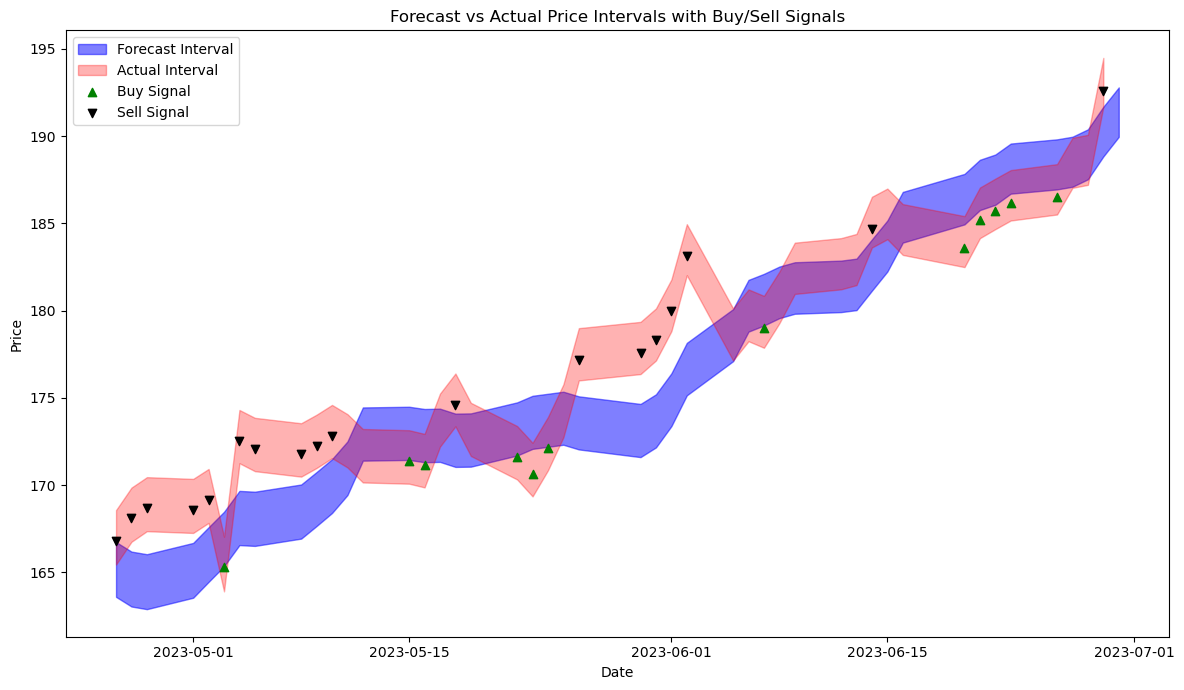

In [56]:
# Identify buy and sell dates
buy_dates = merged_data[merged_data['Signal'] == 'Buy']['Date']
sell_dates = merged_data[merged_data['Signal'] == 'Sell']['Date']
dates = merged_data['Date']

plt.figure(figsize=(12, 7))

# Forecasted price interval
plt.fill_between(dates, merged_data['pred_Low'], merged_data['pred_High'], color='blue', alpha=0.5, label='Forecast Interval')

# Actual price interval
plt.fill_between(dates, merged_data['original_Low'], merged_data['original_High'], color='red', alpha=0.3, label='Actual Interval')

# Buy and sell signals (assuming you have a 'midpoint' column for plotting the signal, if not you might want to use 'original_Mid' or similar)
plt.scatter(buy_dates, merged_data[merged_data['Signal'] == 'Buy']['original_Mid'], color='green', marker='^', label='Buy Signal')
plt.scatter(sell_dates, merged_data[merged_data['Signal'] == 'Sell']['original_Mid'], color='black', marker='v', label='Sell Signal')

plt.title('Forecast vs Actual Price Intervals with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
